# Prediction Of Singapore HDB Prices

## Preparation

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy.stats import iqr
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression,ElasticNetCV,\
RidgeCV,LassoCV,Ridge,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, \
cross_val_predict,GridSearchCV,cross_validate
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
import csv
warnings.filterwarnings('ignore')

### Read Csv into data frame

In [2]:
df = pd.read_csv("../data/train.csv")
df.head(2)

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,...,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,...,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892


## Data cleaning and feature selection

### Check shape, nulls, zeroes and data type

* Created a function to print out columns with null or zero values, and see the data types of the features
* Check the unique values in the columns

In [3]:
def check_dataframe_shape_null_zeroes(df):
    print(f"Data frame shape: {df.shape}")
    print("\n")
    nulls = {k:v for k,v in dict(df.isnull().sum()).items() if v>0}
    for k,v in nulls.items():
        print(f"Empty rows in column [{k}]: {v}")
    print("\n")
    zeroes = {k:v for k,v in dict(df[df == 0].count()).items() if v>0}
    for k,v in zeroes.items():
        print(f"Rows with zeroes in column [{k}]: {v}")
    print("\n")

    column_types = {str(k):list(v) for k,v in df.groupby(df.dtypes,axis=1)}
    for k,v in column_types.items():
        print(f"Columns with data type [{k}]:{v}")
        print("\n")
check_dataframe_shape_null_zeroes(df)

Data frame shape: (150634, 77)


Empty rows in column [Mall_Nearest_Distance]: 829
Empty rows in column [Mall_Within_500m]: 92789
Empty rows in column [Mall_Within_1km]: 25426
Empty rows in column [Mall_Within_2km]: 1940
Empty rows in column [Hawker_Within_500m]: 97390
Empty rows in column [Hawker_Within_1km]: 60868
Empty rows in column [Hawker_Within_2km]: 29202


Rows with zeroes in column [1room_sold]: 150552
Rows with zeroes in column [2room_sold]: 144324
Rows with zeroes in column [3room_sold]: 95671
Rows with zeroes in column [4room_sold]: 30379
Rows with zeroes in column [5room_sold]: 62782
Rows with zeroes in column [exec_sold]: 124614
Rows with zeroes in column [multigen_sold]: 150557
Rows with zeroes in column [studio_apartment_sold]: 149226
Rows with zeroes in column [1room_rental]: 150332
Rows with zeroes in column [2room_rental]: 148770
Rows with zeroes in column [3room_rental]: 146805
Rows with zeroes in column [other_room_rental]: 150602
Rows with zeroes in column [Mall_

In [4]:
len(df['full_flat_type'].unique())

43

In [5]:
len(df['flat_model'].unique())

20

In [6]:
df.groupby("flat_type")['flat_model'].value_counts()

flat_type         flat_model            
1 ROOM            Improved                     82
2 ROOM            Model A                     739
                  Standard                    594
                  Improved                    521
                  Premium Apartment            37
                  2-room                        4
                  DBSS                          1
3 ROOM            New Generation            15227
                  Improved                  10240
                  Model A                    8454
                  Standard                   2522
                  Simplified                 1930
                  Premium Apartment           417
                  DBSS                        184
                  Terrace                      86
4 ROOM            Model A                   35127
                  New Generation             8139
                  Premium Apartment          7667
                  Simplified                 5309
         

### Feature Engineering

* Added feature to indicate the HDB age at the time of transaction

In [7]:
df['hdb_age_at_tranc'] = df['Tranc_Year']-df['lease_commence_date']

### Imputation of null values
* Null values are imputed iwth mean, so we can still include the rows for model training

In [8]:
col = ['Hawker_Within_2km','Mall_Within_2km', 'Mall_Nearest_Distance' ]
for i in col:
    mean = np.mean(df[i])
    df[i].fillna(value=mean, inplace=True)

### Manual splitting into categories and numerical features

* Manually flagged which features are important based on description, analysis and number of null values
* Table below shows the selected features list

In [9]:
numerical_columns = []
categorical_columns = []
filename = "../data/data_dictionary_analysis.csv"
data_dict = pd.read_csv(filename)
with open(filename,'r') as data:
    reader = csv.reader(data)
    next(reader, None)  # skip the headers
    for line in reader:
        if line[3]=='1' and line[4] == 'numerical':
            numerical_columns.append(line[1])
        if line[3]=='1' and line[4] == 'Categorical':
            categorical_columns.append(line[1])

pd.set_option('display.max_colwidth', None)
data_dict = data_dict.loc[data_dict['X']==1][['Feature','Description','Data type']]
data_dict

,Feature,Description,Data type
3,flat_type,"type of the resale flat unit, e.g. 3 ROOM",Categorical
7,floor_area_sqm,floor area of the resale flat unit in square metres,numerical
8,flat_model,"HDB model of the resale flat, e.g. Multi Generation",Categorical
10,Tranc_Year,year of resale transaction,Categorical
15,mid,middle value of storey_range,numerical
20,max_floor_lvl,highest floor of the resale flat,numerical
43,planning_area,Government planning area that the flat is located,Categorical
54,mrt_nearest_distance,distance (in metres) to the nearest MRT station,numerical
76,hdb_age_at_tranc,hdb age during the transaction date,numerical


### Check data types

* Double check the data type of the dataframe agrees with numerical and categorical classification

In [10]:
for i in numerical_columns:
    print(f"Column [{i}] has data type [{df[i].dtype}]")
    
for i in categorical_columns:
    print(f"Column [{i}] has data type [{df[i].dtype}] has unique counts [{len(set(df[i]))}]")

Column [floor_area_sqm] has data type [float64]
Column [mid] has data type [int64]
Column [max_floor_lvl] has data type [int64]
Column [mrt_nearest_distance] has data type [float64]
Column [hdb_age_at_tranc] has data type [int64]
Column [flat_type] has data type [object] has unique counts [7]
Column [flat_model] has data type [object] has unique counts [20]
Column [Tranc_Year] has data type [int64] has unique counts [10]
Column [planning_area] has data type [object] has unique counts [32]


## EDA

### Correlation heat map of numerical columns

* Check the correlation of numerical values with resale prices
* The highest feature is floor area and max floor level or mid storey

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0.5, 0, 'floor_area_sqm'),
  Text(1.5, 0, 'mid'),
  Text(2.5, 0, 'max_floor_lvl'),
  Text(3.5, 0, 'mrt_nearest_distance'),
  Text(4.5, 0, 'hdb_age_at_tranc'),
  Text(5.5, 0, 'resale_price')])

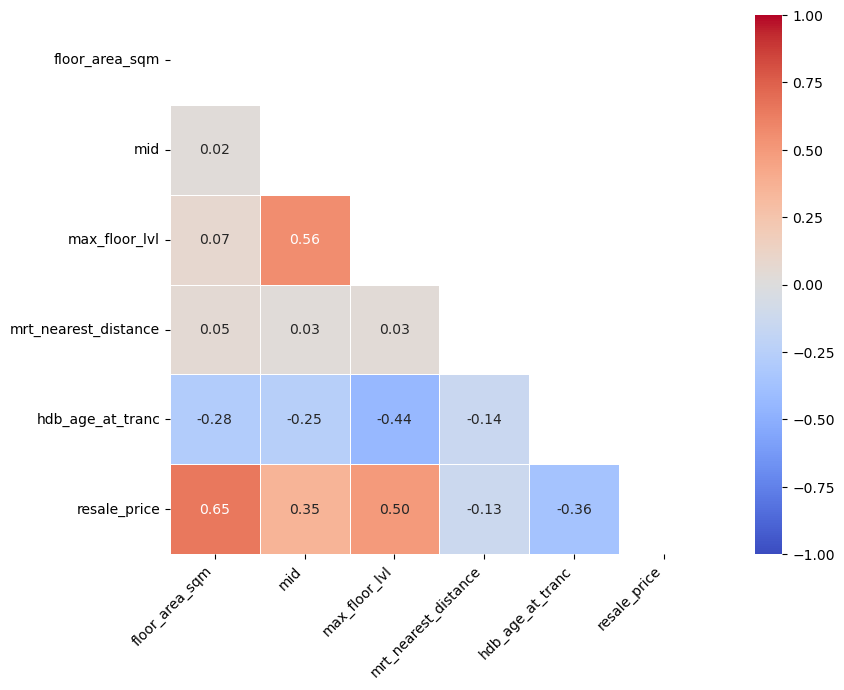

In [11]:
# Use Seaborn's heatmap with pandas .corr() to visualize correlations between all numeric features.
corr = df[numerical_columns+['resale_price']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (12,7))
sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap = "coolwarm",fmt='.2f')
plt.xticks(rotation=45, ha='right') 

Note:
* Remove max_floor_level feature due to correlation with 2 other features

In [12]:
numerical_columns.remove("max_floor_lvl")
numerical_columns

['floor_area_sqm', 'mid', 'mrt_nearest_distance', 'hdb_age_at_tranc']

### Bar charts for categorical features

* Visualise the distribution of flat type, flat model, transaction year amd planning area

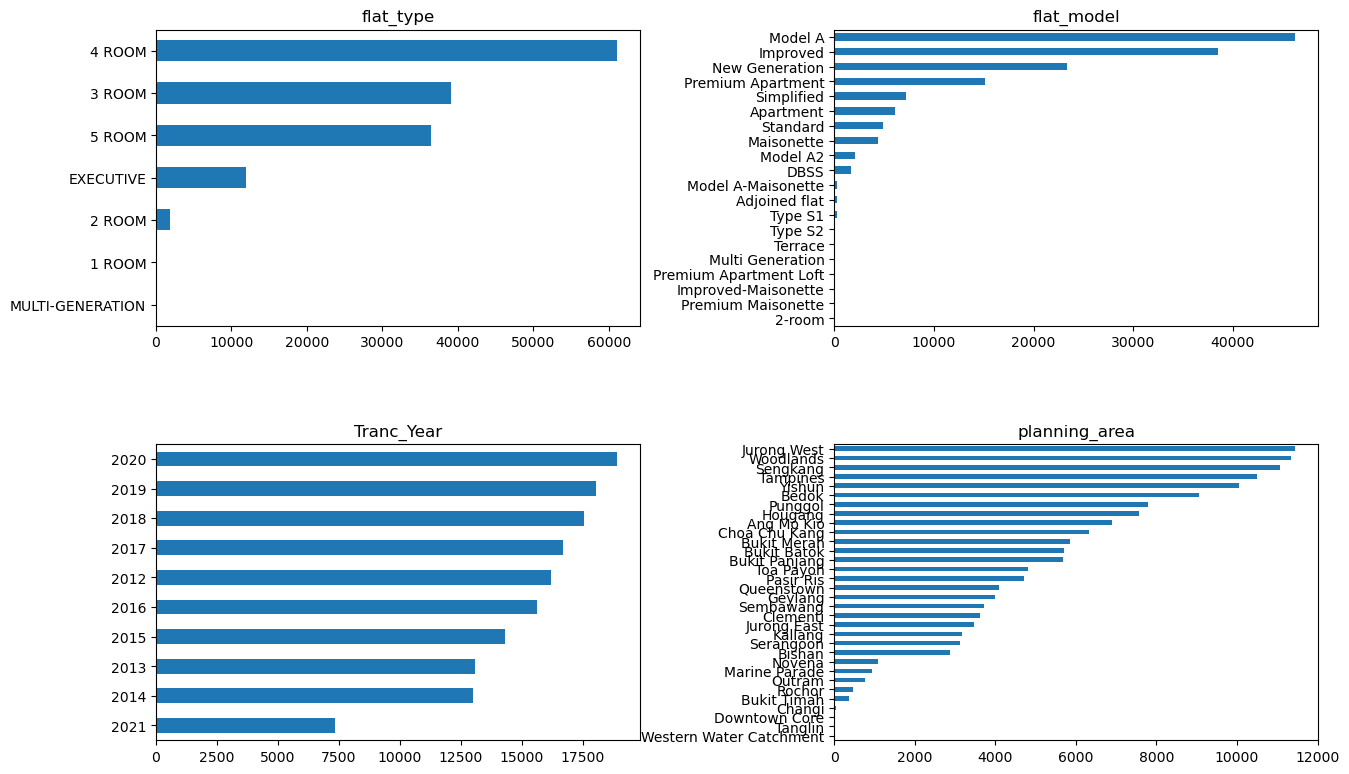

In [13]:
fig1 = plt.figure(figsize=(15,20))
fig1.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(categorical_columns):
    fig1.add_subplot(4,2,idx+1)
    df[d].value_counts().sort_values().plot(kind='barh')
    plt.title(d)

### Histogram for numerical features

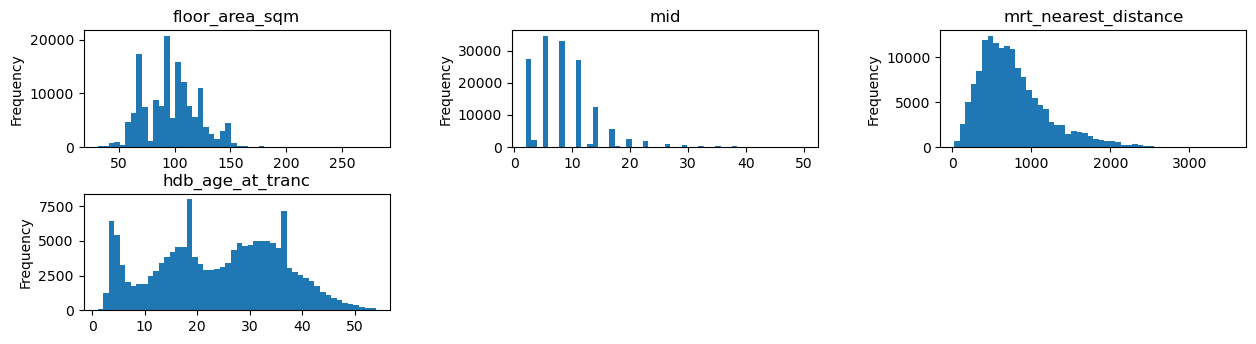

In [14]:
fig1b = plt.figure(figsize=(15,10))
fig1b.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(numerical_columns):
    fig1b.add_subplot(5,3,idx+1)
    df[d].plot(kind='hist',bins=50,title=d)

### Scatter plots by Flat Model

Grouping by Flat model, the resale prices and floor area shows some linear correlation

In [15]:
list(df['flat_type'].value_counts()[:3].index)

['4 ROOM', '3 ROOM', '5 ROOM']

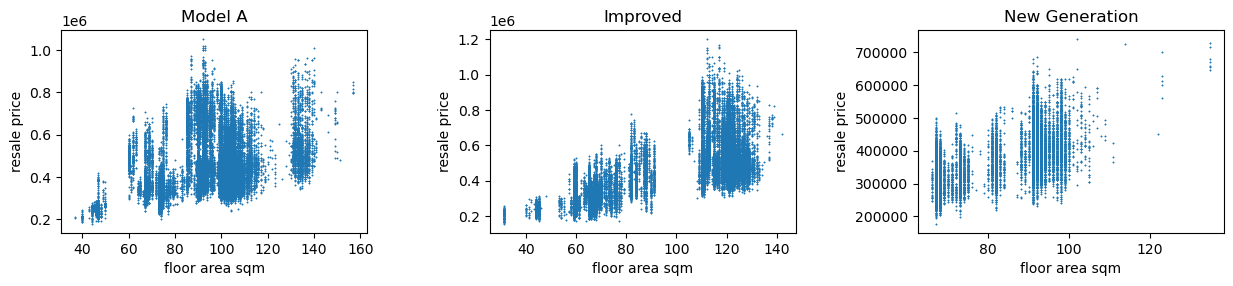

In [16]:
fig3 = plt.figure(figsize=(15,10))
fig3.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(df['flat_model'].value_counts()[:3].index):
    x = df.loc[df['flat_model']==d]['floor_area_sqm']
    y = df.loc[df['flat_model']==d]['resale_price']
    fig3.add_subplot(3,3,idx+1)
    plt.scatter(x,y, marker='*',s=0.1)
    plt.xlabel('floor area sqm')
    plt.ylabel('resale price')
    plt.title(d)

### Scatter plots by Planning area

After grouping by planning area, we can see stronger linear correlation between floor area and resale prices

In [17]:
list(df['planning_area'].value_counts()[:3].index)

['Jurong West', 'Woodlands', 'Sengkang']

fig4 = plt.figure(figsize=(15,40))
fig4.subplots_adjust(hspace=0.4,wspace=0.4)
for idx, d in enumerate(['Jurong West', 'Woodlands', 'Sengkang']):
    x = df.loc[(df['planning_area']==d)]['floor_area_sqm']
    y = df.loc[(df['planning_area']==d)]['resale_price']
    fig4.add_subplot(11,3,idx+1)
    plt.scatter(x,y, marker='*',s=0.1)
    plt.xlabel('floor area sqm')
    plt.ylabel('resale price')
    plt.title(d)

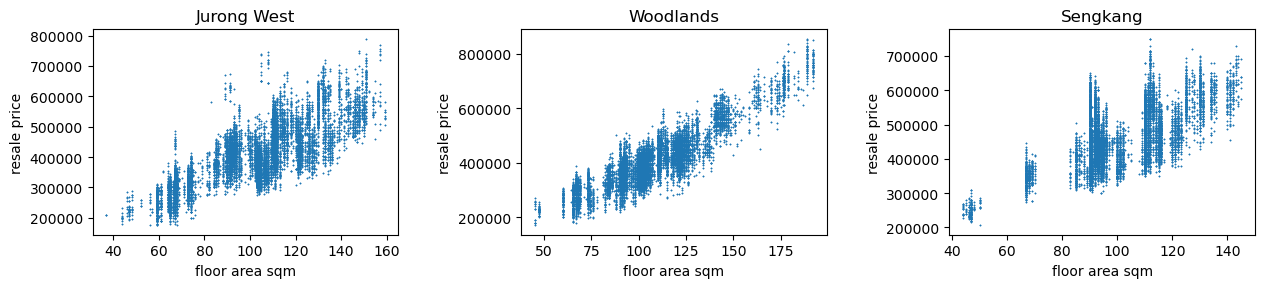

In [18]:
fig4 = plt.figure(figsize=(15,40))
fig4.subplots_adjust(hspace=0.4,wspace=0.4)
for idx, d in enumerate(['Jurong West', 'Woodlands', 'Sengkang']):
    x = df.loc[(df['planning_area']==d)]['floor_area_sqm']
    y = df.loc[(df['planning_area']==d)]['resale_price']
    fig4.add_subplot(11,3,idx+1)
    plt.scatter(x,y, marker='*',s=0.1)
    plt.xlabel('floor area sqm')
    plt.ylabel('resale price')
    plt.title(d)

### Notes:
* Resale prices are more linearly correlated with floor area when grouped by planning areas than flat type

## Finding Outliers
* Scatter plot to check for outliers
* Box plots to focus on outliers for selected planning area
* Remove outliers from the dataset

Text(0.5, 1.0, 'Floor Area vs resale price')

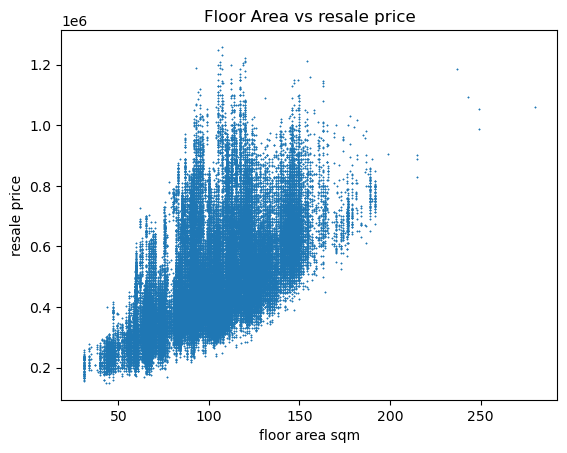

In [19]:
x = df['floor_area_sqm']
y = df['resale_price']
plt.scatter(x,y, marker='*',s=0.1)
plt.xlabel('floor area sqm')
plt.ylabel('resale price')
plt.title('Floor Area vs resale price')

### Removing outliers

In [20]:
col = 'planning_area'

In [21]:
def get_iqr(df):
    Q1 = np.percentile(df['resale_price'], 50)
    Q3 = np.percentile(df['resale_price'], 75)
    return (Q3 - Q1)

threshold = get_iqr(df)
threshold

100000.0

In [22]:
pd.options.display.float_format = '{:.2f}'.format
outliers_1 = df.groupby('planning_area')['resale_price'].agg(iqr).sort_values(ascending=False)
outliers = pd.cut(outliers_1, bins=[0,160000,500000],labels=[1,2])
outliers

planning_area
Outram                     2
Queenstown                 2
Bukit Merah                2
Toa Payoh                  2
Bukit Timah                2
Novena                     2
Tanglin                    2
Kallang                    2
Geylang                    2
Bishan                     2
Clementi                   2
Serangoon                  2
Jurong East                2
Marine Parade              2
Bedok                      2
Ang Mo Kio                 2
Bukit Batok                2
Hougang                    1
Downtown Core              1
Tampines                   1
Bukit Panjang              1
Jurong West                1
Pasir Ris                  1
Rochor                     1
Sengkang                   1
Yishun                     1
Choa Chu Kang              1
Woodlands                  1
Sembawang                  1
Punggol                    1
Western Water Catchment    1
Changi                     1
Name: resale_price, dtype: category
Categories (2, int64):

In [23]:
area_1 = list(outliers[outliers==1].index)
area_2 = list(outliers[outliers==2].index)

In [24]:
print(f"Before Original DataFrame : {df.shape}")

df_1 = df.loc[df[col].isin(area_1)]
df_2 = df.loc[df[col].isin(area_2)]

print(f"Dataframe 1: {df_1.shape}")
print(f"DataFrame 2: {df_2.shape}")

Before Original DataFrame : (150634, 78)
Dataframe 1: (90766, 78)
DataFrame 2: (59868, 78)


### Check if splitting dataset works to get 2 different gradients

Text(0.5, 1.0, 'Floor Area vs resale price (Planning Area 1)')

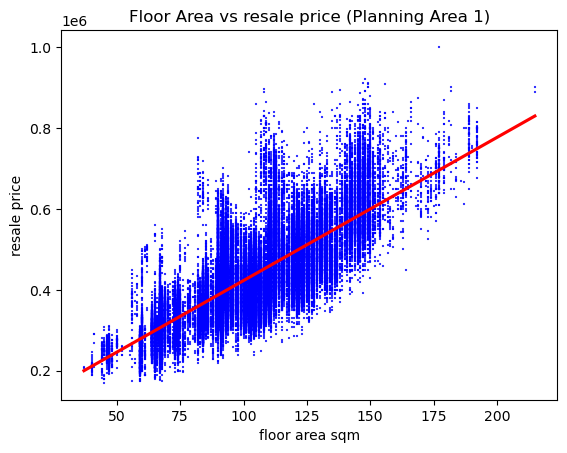

In [25]:
x = df_1['floor_area_sqm']
y = df_1['resale_price']
sns.regplot(x=x, y=y,marker="+",color='green',scatter_kws={"color": "blue",'s':2}, line_kws={"color": "red"})
plt.xlabel('floor area sqm')
plt.ylabel('resale price')
plt.title('Floor Area vs resale price (Planning Area 1)')

## Notes: 
* First dataset is based on planning areas of lower IQR, the variables are more linearly correlated. 

Text(0.5, 1.0, 'Floor Area vs resale price (Planning Area 2)')

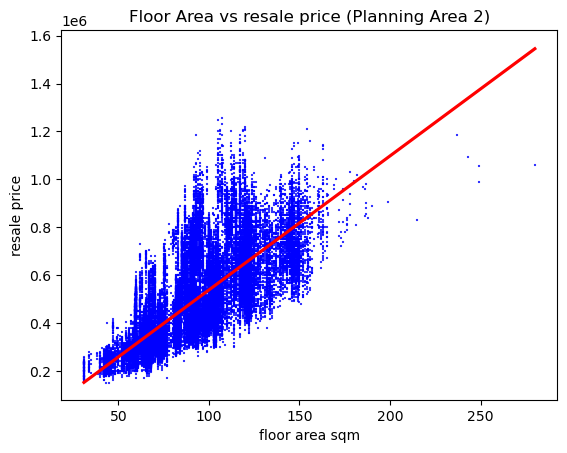

In [26]:
x = df_2['floor_area_sqm']
y = df_2['resale_price']
sns.regplot(x=x, y=y,marker="+",color='green',scatter_kws={"color": "blue",'s':2}, line_kws={"color": "red"})
plt.xlabel('floor area sqm')
plt.ylabel('resale price')
plt.title('Floor Area vs resale price (Planning Area 2)')

## Notes: 
* Above 2 plots illustrated the attempt to split the dataset into 2 more linearly correlated plots by splitting on subsets of planning areas
* Outcome looks better than original combined dataset
* The criteria to split based on planning areas is the interquartile of the resale flat prices
* However, the second dataset still appears to be Fan-shaped, most likely due to flat model and other variables

## Feature Engineering and Train Test Split

### Setup features and target

* Let X be the combination of selected numerical and categorical columns
* Let y be the target resale price column
* Suffix _1 represents the first dataset based on first group of planning areas of lower IQR
* Suffix _2 represents the first dataset based on second group of planning areas of higher IQR

In [27]:
X_1= df_1[numerical_columns+categorical_columns]
y_1= df_1['resale_price']

X_2= df_2[numerical_columns+categorical_columns]
y_2= df_2['resale_price']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1,y_1,test_size = 0.2,random_state = 42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,y_2,test_size = 0.2,random_state = 42)

## Model Building

* We will be using linear regression with regularisation
* Create a pipeline with 2 steps: 
1. Preprocessing of numerical columns using standard scaler, and categorical columns with one hot encoding
2. Estimation using Linear regression or Ridge Regression

In [28]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

* Cell below is turned off as it takes too long to run

### Model selection
* After running through the grid search, Linear, Ridge, Lasso appears to give similar RMSE score, so we will stick to using Ridge

In [29]:
%%time
model = Ridge()
pipe = make_pipeline(preprocessor, model)
hyperparameters = {'ridge__alpha': [0.001, 0.01, 0.1,1,10]}
gs_1 = GridSearchCV(pipe, hyperparameters,cv=5,scoring='neg_root_mean_squared_error')
gs_1.fit(X_train_1,y_train_1)
print(f"Best Score for area 1: {-gs_1.best_score_}")
print(f"Best Params for area 1: {gs_1.best_params_}")

Best Score for area 1: 37473.21746867131
Best Params for area 1: {'ridge__alpha': 1}
CPU times: total: 28.3 s
Wall time: 12.5 s


In [30]:
%%time
gs_2 = GridSearchCV(pipe, hyperparameters,cv=5,scoring='neg_root_mean_squared_error')
gs_2.fit(X_train_2,y_train_2)
print(f"Best Score for area 2: {-gs_2.best_score_}")
print(f"Best Params for area 2: {gs_2.best_params_}")

Best Score for area 2: 53070.64592988271
Best Params for area 2: {'ridge__alpha': 0.1}
CPU times: total: 22.2 s
Wall time: 8 s


In [31]:
results_1 = pd.DataFrame(gs_1.cv_results_)
results_2 = pd.DataFrame(gs_2.cv_results_)

## Notes:

* By separating the dataset into main and outlier, the main model has a better RMSE score.

## Model Evaluation

In [32]:
predicted = gs_1.best_estimator_.predict(X_test_1)
mse = metrics.mean_squared_error(y_test_1, predicted)
print(f"Test score for area 1= {np.sqrt(mse):.3f}")
print("The mean cross-validation rmse for area 1 is: "
      f"{-results_1['mean_test_score'].mean():.0f} ± {results_1['std_test_score'].mean():.0f}")

predicted = gs_2.best_estimator_.predict(X_test_2)
mse = metrics.mean_squared_error(y_test_2, predicted)
print(f"Test score for area 2 = {np.sqrt(mse):.3f}")
print("The mean cross-validation rmse for area 2 is: "
      f"{-results_2['mean_test_score'].mean():.0f} ± {results_2['std_test_score'].mean():.0f}")

Test score for area 1= 37833.085
The mean cross-validation rmse for area 1 is: 37503 ± 194
Test score for area 2 = 53024.059
The mean cross-validation rmse for area 2 is: 53092 ± 413


In [33]:
def get_coeffs_from_gs(gs):
    coefficients = gs.best_estimator_[1].coef_
    out_columns_numerical = gs.best_estimator_[0].transformers_[1][2]
    out_columns_category = list(gs.best_estimator_[0].transformers_[0][1].get_feature_names())
    out_columns = out_columns_category+out_columns_numerical
    gs_coef = sorted(list(zip(np.round(coefficients,3),out_columns)),key=lambda x: x[0],reverse=True)
    return gs_coef

In [34]:
coefs = get_coeffs_from_gs(gs_1)
print("Flat Type")
print(*[x for x in coefs if "x0" in x[1]],sep='\n')
print("Flat Model")
print(*[x for x in coefs if "x1" in x[1]],sep='\n')
print("Transaction Year")
print(*[x for x in coefs if "x2" in x[1]],sep='\n')
print("Planning Area")
print(*[x for x in coefs if "x3" in x[1]],sep='\n')
print("Numerical Features")
print(*[x for x in coefs if not x[1].startswith('x')],sep='\n')

Flat Type
(65634.601, 'x0_MULTI-GENERATION')
(24648.639, 'x0_EXECUTIVE')
(-8247.04, 'x0_5 ROOM')
(-10601.57, 'x0_4 ROOM')
(-13489.985, 'x0_3 ROOM')
(-57944.646, 'x0_2 ROOM')
Flat Model
(88772.667, 'x1_DBSS')
(68571.74, 'x1_Model A-Maisonette')
(68541.67, 'x1_Improved-Maisonette')
(65634.601, 'x1_Multi Generation')
(57463.637, 'x1_Premium Apartment Loft')
(31150.319, 'x1_Premium Maisonette')
(27170.518, 'x1_Adjoined flat')
(10112.958, 'x1_Maisonette')
(-5138.534, 'x1_2-room')
(-26632.979, 'x1_Standard')
(-27158.313, 'x1_Apartment')
(-47368.852, 'x1_Premium Apartment')
(-52001.946, 'x1_New Generation')
(-54053.124, 'x1_Improved')
(-62067.713, 'x1_Simplified')
(-71376.518, 'x1_Model A')
(-71620.132, 'x1_Model A2')
Transaction Year
(34660.365, 'x2_2013')
(32060.641, 'x2_2021')
(18427.907, 'x2_2012')
(2195.499, 'x2_2014')
(1496.895, 'x2_2020')
(-15760.05, 'x2_2019')
(-16103.189, 'x2_2016')
(-17049.036, 'x2_2015')
(-18836.064, 'x2_2017')
(-21092.969, 'x2_2018')
Planning Area
(200442.876, 'x3

In [35]:
coefs = get_coeffs_from_gs(gs_2)
print("Flat Type")
print(*[x for x in coefs if "x0" in x[1]],sep='\n')
print("Flat Model")
print(*[x for x in coefs if "x1" in x[1]],sep='\n')
print("Transaction Year")
print(*[x for x in coefs if "x2" in x[1]],sep='\n')
print("Planning Area")
print(*[x for x in coefs if "x3" in x[1]],sep='\n')
print("Numerical Features")
print(*[x for x in coefs if not x[1].startswith('x')],sep='\n')

Flat Type
(54265.083, 'x0_5 ROOM')
(25041.152, 'x0_EXECUTIVE')
(9217.093, 'x0_MULTI-GENERATION')
(7038.459, 'x0_4 ROOM')
(-179.955, 'x0_1 ROOM')
(-30676.704, 'x0_3 ROOM')
(-64705.127, 'x0_2 ROOM')
Flat Model
(345339.279, 'x1_Terrace')
(86576.49, 'x1_Type S2')
(42319.586, 'x1_Type S1')
(24206.749, 'x1_Premium Apartment Loft')
(20921.483, 'x1_Model A-Maisonette')
(9723.622, 'x1_DBSS')
(9217.093, 'x1_Multi Generation')
(-2101.061, 'x1_Adjoined flat')
(-2429.846, 'x1_Maisonette')
(-4520.831, 'x1_Apartment')
(-47732.191, 'x1_Standard')
(-64409.869, 'x1_Model A2')
(-66113.855, 'x1_New Generation')
(-74453.073, 'x1_Improved')
(-83852.807, 'x1_Model A')
(-94442.042, 'x1_Simplified')
(-98248.728, 'x1_Premium Apartment')
Transaction Year
(26428.086, 'x2_2021')
(17511.107, 'x2_2013')
(-1105.241, 'x2_2014')
(-3186.967, 'x2_2017')
(-3389.221, 'x2_2020')
(-3971.915, 'x2_2012')
(-4778.768, 'x2_2016')
(-7651.79, 'x2_2018')
(-9222.743, 'x2_2015')
(-10632.548, 'x2_2019')
Planning Area
(180498.429, 'x3_M

## Prediction

In [36]:
test_df = pd.read_csv("../data/test.csv")
test_df.head(2)

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,114982,2012-11,YISHUN,4 ROOM,173,YISHUN AVE 7,07 TO 09,84.00,Simplified,1987,...,92,0,1.43,103.83,156.32,Ahmad Ibrahim Secondary School,218,0,1.44,103.83
1,95653,2019-08,JURONG WEST,5 ROOM,986C,JURONG WEST ST 93,04 TO 06,112.00,Premium Apartment,2008,...,45,0,1.34,103.70,739.37,Jurong West Secondary School,199,0,1.34,103.70


In [37]:
check_dataframe_shape_null_zeroes(test_df)

Data frame shape: (16737, 76)


Empty rows in column [Mall_Nearest_Distance]: 84
Empty rows in column [Mall_Within_500m]: 10292
Empty rows in column [Mall_Within_1km]: 2786
Empty rows in column [Mall_Within_2km]: 213
Empty rows in column [Hawker_Within_500m]: 10755
Empty rows in column [Hawker_Within_1km]: 6729
Empty rows in column [Hawker_Within_2km]: 3254


Rows with zeroes in column [1room_sold]: 16730
Rows with zeroes in column [2room_sold]: 16027
Rows with zeroes in column [3room_sold]: 10607
Rows with zeroes in column [4room_sold]: 3297
Rows with zeroes in column [5room_sold]: 7002
Rows with zeroes in column [exec_sold]: 13916
Rows with zeroes in column [multigen_sold]: 16727
Rows with zeroes in column [studio_apartment_sold]: 16592
Rows with zeroes in column [1room_rental]: 16711
Rows with zeroes in column [2room_rental]: 16516
Rows with zeroes in column [3room_rental]: 16319
Rows with zeroes in column [other_room_rental]: 16736
Rows with zeroes in column [Mall_Nearest_Distance]

In [38]:
test_df['hdb_age_at_tranc'] = test_df['Tranc_Year']-test_df['lease_commence_date']

In [39]:
col = ['Hawker_Within_2km','Mall_Within_2km', 'Mall_Nearest_Distance' ]
for i in col:
    mean = np.mean(test_df[i])
    test_df[i].fillna(value=mean, inplace=True)

In [40]:
print(f"Before Original DataFrame : {test_df.shape}")

col = 'planning_area'
test_df_1 = test_df.loc[test_df['planning_area'].isin(area_1)]
test_df_2 = test_df.loc[test_df['planning_area'].isin(area_2)]

print(f"Dataframe area 1: {test_df_1.shape}")
print(f"DataFrame area 2: {test_df_2.shape}")

Before Original DataFrame : (16737, 77)
Dataframe area 1: (9989, 77)
DataFrame area 2: (6748, 77)


In [41]:
pred_1 = gs_1.best_estimator_.predict(test_df_1)
pred_1.shape

(9989,)

In [42]:
pred_2 = gs_2.best_estimator_.predict(test_df_2)
pred_2.shape

(6748,)

In [43]:
sub_df = pd.DataFrame()
sub_df["Id"] = test_df_1['id'].append(test_df_2['id'])
sub_df["Predicted"] = np.concatenate((pred_1,pred_2), axis=0)
sub_df.to_csv("../data/sub_reg.csv", index=False)

In [44]:
submit = pd.read_csv("../data/sub_reg.csv")
submit.shape

(16737, 2)

In [45]:
submit.head()

,Id,Predicted
0,114982,379942.89
1,95653,487743.14
2,109506,259477.49
3,61101,352171.03
4,65701,369835.29
